<a href="https://colab.research.google.com/github/fjadidi2001/DataScienceJourney/blob/master/fake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Step 1: Dataset Loading

In [ ]:
def load_dataset():
    """
    Load the news dataset. Using a well-known fake news dataset from Kaggle.
    """
    print("Step 1: Loading Dataset...")

    # Load the data
    true_news = pd.read_csv('True.csv')
    fake_news = pd.read_csv('Fake.csv')

    # Add labels to the datasets
    true_news['label'] = 1  # 1 for true news
    fake_news['label'] = 0  # 0 for fake news

    # Combine the datasets
    df = pd.concat([true_news, fake_news], ignore_index=True)

    # Shuffle the dataset
    df = df.sample(frac=1).reset_index(drop=True)

    print(f"Dataset loaded successfully with {len(df)} entries.")
    return df


# Step 2: Data Cleaning


In [ ]:
def clean_data(df):
    """
    Clean the dataset by removing null values and unnecessary columns.
    """
    print("Step 2: Cleaning Data...")

    # Check for null values
    print(f"Null values before cleaning: {df.isnull().sum().sum()}")

    # Drop rows with null values
    df = df.dropna()

    # Keep only relevant columns (title, text, and label)
    if 'title' in df.columns and 'text' in df.columns:
        df = df[['title', 'text', 'label']]
    elif 'text' in df.columns:
        df = df[['text', 'label']]

    print(f"Null values after cleaning: {df.isnull().sum().sum()}")
    print(f"Dataset shape after cleaning: {df.shape}")

    return df


 # Step 3: Text Processing (NLP)


In [ ]:
def preprocess_text(df):
    """
    Perform text preprocessing using NLP techniques:
    - Tokenization
    - Stop words removal
    - Punctuation removal
    - Stemming
    """
    print("Step 3: Preprocessing Text...")

    # Initialize stemmer
    stemmer = PorterStemmer()

    # Get English stopwords
    stop_words = set(stopwords.words('english'))

    def clean_text(text):
        # Convert to lowercase
        text = text.lower()

        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)

        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)

        # Remove punctuation and special characters
        text = re.sub(r'[^\w\s]', '', text)

        # Remove numbers
        text = re.sub(r'\d+', '', text)

        # Tokenize
        tokens = nltk.word_tokenize(text)

        # Remove stopwords and apply stemming
        cleaned_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words and len(word) > 2]

        return ' '.join(cleaned_tokens)

    # Apply text cleaning to the 'text' column
    df['processed_text'] = df['text'].apply(clean_text)

    # If title column exists, process it too and combine with text
    if 'title' in df.columns:
        df['processed_title'] = df['title'].apply(clean_text)
        df['processed_content'] = df['processed_title'] + ' ' + df['processed_text']
    else:
        df['processed_content'] = df['processed_text']

    print("Text preprocessing completed.")
    return df


# Step 4: Feature Extraction (Vectorization)


In [ ]:
def vectorize_text(df_train, df_test, method='tfidf'):
    """
    Convert text to numerical vectors using either TF-IDF or Bag of Words
    """
    print(f"Step 4: Vectorizing Text using {method}...")

    if method == 'tfidf':
        # TF-IDF Vectorization
        vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
    else:
        # Bag of Words Vectorization
        vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 2))

    # Fit and transform the training data
    X_train = vectorizer.fit_transform(df_train['processed_content'])

    # Transform the test data
    X_test = vectorizer.transform(df_test['processed_content'])

    print(f"Vectorization completed. Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")
    return X_train, X_test, vectorizer

# Step 5: Machine Learning Models


In [ ]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """
    Train and evaluate multiple machine learning models:
    - Random Forest
    - Decision Tree
    - Support Vector Machine
    """
    print("Step 5: Training and Evaluating Machine Learning Models...")

    # Define models
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'SVM': SVC(kernel='linear', random_state=42, probability=True)
    }

    results = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)

        # Generate classification report
        report = classification_report(y_test, y_pred, output_dict=True)

        # Generate confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'report': report,
            'confusion_matrix': cm
        }

        print(f"{name} Accuracy: {accuracy:.4f}")

    return results


# Step 6: Visualize Results


In [ ]:
def visualize_results(results):
    """
    Visualize the performance of different models
    """
    print("Step 6: Visualizing Results...")

    # Plot accuracy comparison
    plt.figure(figsize=(10, 6))
    accuracies = [results[model]['accuracy'] for model in results.keys()]
    plt.bar(results.keys(), accuracies, color=['blue', 'green', 'red'])
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    for i, v in enumerate(accuracies):
        plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
    plt.savefig('model_accuracy_comparison.png')

    # Plot confusion matrices
    for name, result in results.items():
        plt.figure(figsize=(8, 6))
        cm = result['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Fake', 'True'],
                   yticklabels=['Fake', 'True'])
        plt.title(f'Confusion Matrix - {name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.savefig(f'confusion_matrix_{name.replace(" ", "_").lower()}.png')

    print("Visualization completed. Results saved as images.")


# Main function to run the entire pipeline


In [ ]:
def main():
    """
    Main function to execute the complete fake news detection pipeline
    """
    print("Starting Fake News Detection System...")

    # Step 1: Load dataset
    df = load_dataset()

    # Step 2: Clean data
    df = clean_data(df)

    # Step 3: Preprocess text
    df = preprocess_text(df)

    # Split data into training and testing sets (80:20 ratio)
    df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

    # Extract labels
    y_train = df_train['label']
    y_test = df_test['label']

    # Step 4: Vectorize text
    X_train, X_test, vectorizer = vectorize_text(df_train, df_test, method='tfidf')

    # Step 5: Train and evaluate models
    results = train_and_evaluate_models(X_train, X_test, y_train, y_test)

    # Step 6: Visualize results
    visualize_results(results)

    # Find the best model
    best_model_name = max(results, key=lambda x: results[x]['accuracy'])
    best_accuracy = results[best_model_name]['accuracy']

    print(f"\nBest performing model: {best_model_name} with accuracy {best_accuracy:.4f}")
    print("\nFake News Detection System completed successfully!")

    # Save the best model and vectorizer for future use
    import joblib
    joblib.dump(results[best_model_name]['model'], f'best_model_{best_model_name.lower().replace(" ", "_")}.pkl')
    joblib.dump(vectorizer, 'vectorizer.pkl')
    print(f"Best model and vectorizer saved for future use.")

    return results

# Function to make predictions on new data


In [ ]:
def predict_news(text, model, vectorizer):
    """
    Make predictions on new news articles
    """
    # Preprocess the text
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))

    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    tokens = nltk.word_tokenize(text)
    cleaned_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words and len(word) > 2]
    processed_text = ' '.join(cleaned_tokens)

    # Vectorize the text
    text_vector = vectorizer.transform([processed_text])

    # Make prediction
    prediction = model.predict(text_vector)[0]
    prediction_proba = model.predict_proba(text_vector)[0]

    # Return result
    if prediction == 1:
        return "True News", prediction_proba[1]
    else:
        return "Fake News", prediction_proba[0]

Starting Fake News Detection System...
Step 1: Loading Dataset...
Dataset loaded successfully with 44898 entries.
Step 2: Cleaning Data...
Null values before cleaning: 0
Null values after cleaning: 0
Dataset shape after cleaning: (44898, 3)
Step 3: Preprocessing Text...
Text preprocessing completed.
Step 4: Vectorizing Text using tfidf...
Vectorization completed. Training set shape: (35918, 5000), Test set shape: (8980, 5000)
Step 5: Training and Evaluating Machine Learning Models...

Training Random Forest...
Random Forest Accuracy: 0.9974

Training Decision Tree...
Decision Tree Accuracy: 0.9957

Training SVM...
SVM Accuracy: 0.9951
Step 6: Visualizing Results...
Visualization completed. Results saved as images.

Best performing model: Random Forest with accuracy 0.9974

Fake News Detection System completed successfully!
Best model and vectorizer saved for future use.

Prediction for sample news: Fake News (Confidence: 0.8200)


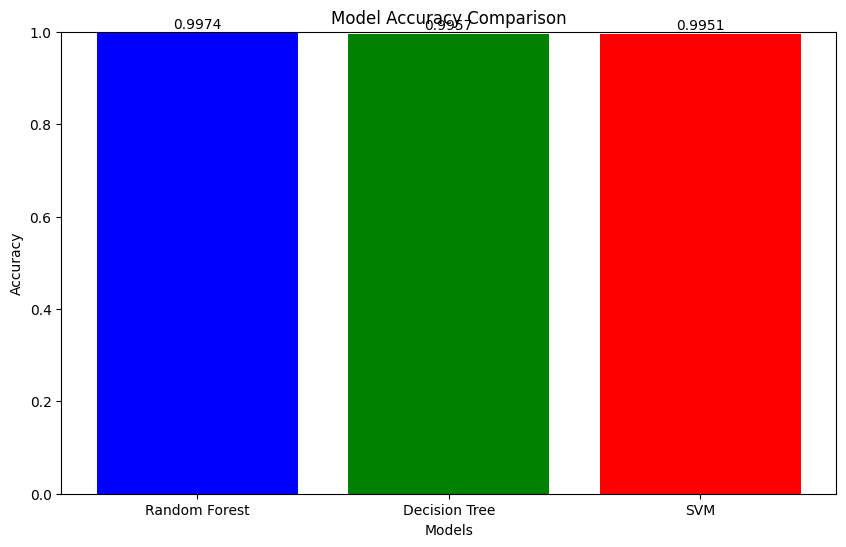

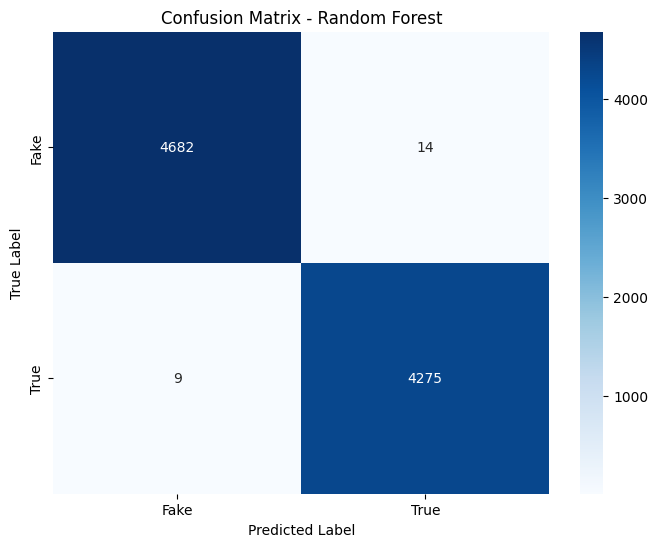

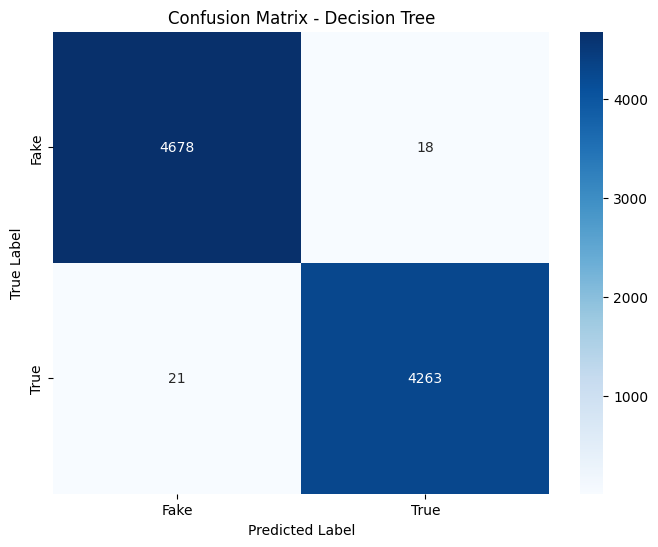

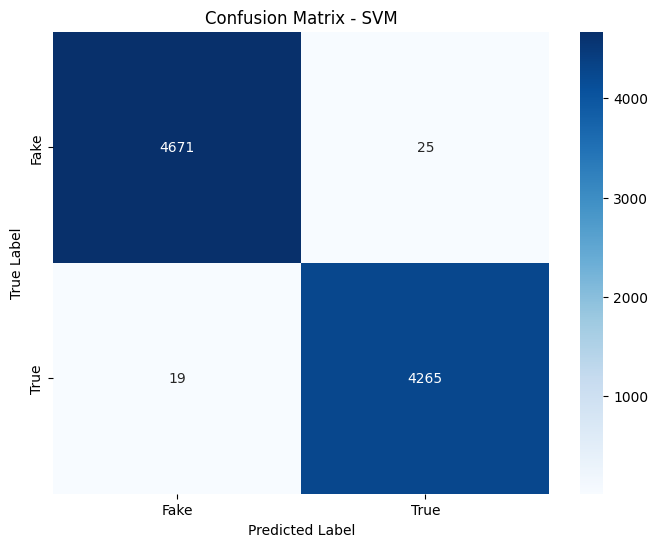

In [ ]:
# Example usage of the system
if __name__ == "__main__":
    # Run the main pipeline
    results = main()

    # Load the best model and vectorizer for making predictions
    import joblib
    best_model_name = max(results, key=lambda x: results[x]['accuracy'])
    model = results[best_model_name]['model']
    vectorizer = joblib.load('vectorizer.pkl')

    # Example news article for prediction
    sample_news = """
    Scientists discover new treatment for cancer that shows promising results in early trials.
    The research team at University Medical Center has developed a novel approach that targets specific cancer cells
    without damaging healthy tissue. The treatment has been tested on a small group of patients with advanced forms of
    cancer, and initial results show significant tumor reduction in 85% of participants. The team plans to expand the
    clinical trials next year after receiving additional funding from the National Health Institute.
    """

    # Make prediction
    result, confidence = predict_news(sample_news, model, vectorizer)
    print(f"\nPrediction for sample news: {result} (Confidence: {confidence:.4f})")